In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("./immo_data.csv",)#.sample(30000)

In [57]:
df.index

RangeIndex(start=0, stop=268850, step=1)

Text(0.5, 0.98, 'Token counts')

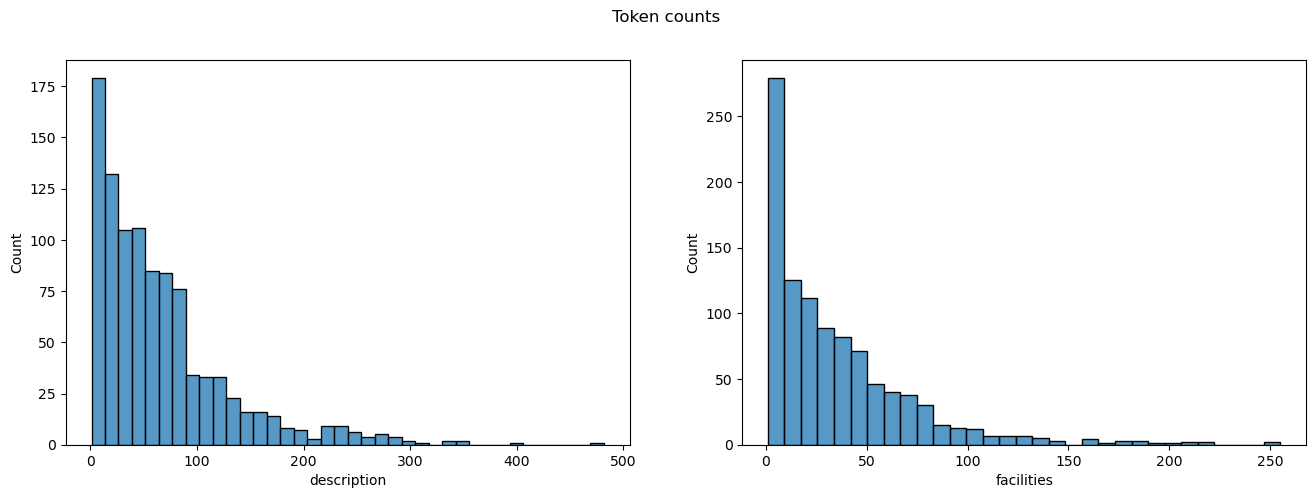

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))
sns.histplot(df['description'].apply(lambda x: len(str(x).split())).sample(1000), ax=axes[0])
sns.histplot(df['facilities'].apply(lambda x: len(str(x).split())).sample(1000), ax=axes[1])
fig.suptitle('Token counts')

In [3]:
df['facilities'].isna().sum()

52924

In [4]:
from catboost.text_processing import Tokenizer

simple_tokenizer = Tokenizer(
    # lowercasing=True,
    separator_type='BySense',
    token_types=['Word', 'Number','SentenceBreak'],
    languages=['en','de']
)

def break_cleaner(x: str):
    x = x.replace('\r','')
    x = x.replace('\n','')
    return x

def clean_texts(texts):
    return [' '.join(simple_tokenizer.tokenize(break_cleaner(text))).replace(' . ','.') for text in texts]

tokenized_text = clean_texts(df['description'].astype(str)[:2])
tokenized_text[0]

'Die ebenerdig zu erreichende Erdgeschosswohnung befindet sich in einem gepflegten 8 Familienhaus. Aufgrund der Hanglage bietet sich ein unverbaubarer Blick ins Grüne'

In [5]:
from sentence_transformers import SentenceTransformer

text_model = SentenceTransformer("distiluse-base-multilingual-cased-v1")
text_model.max_seq_length = 150
text_model

/Users/korhanpolat/miniconda3/envs/swc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SentenceTransformer(
  (0): Transformer({'max_seq_length': 150, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [6]:
sentences = clean_texts(df['description'].astype(str).apply(break_cleaner).values[:15])


# Sentences are encoded by calling model.encode()
sentence_embeddings = text_model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Sentence Length:", len(sentence.split()))
    print("Embedding:", embedding.shape)
    print("")


Sentence: Die ebenerdig zu erreichende Erdgeschosswohnung befindet sich in einem gepflegten 8 Familienhaus. Aufgrund der Hanglage bietet sich ein unverbaubarer Blick ins Grüne
Sentence Length: 22
Embedding: (512,)

Sentence: Alles neu macht der Mai so kann es auch für Sie in 2019 sein !  Genießen Sie das reine Gefühl und die Unberührtheit die diese Wohnung nach der Kernsanierung bietet Sie verfügt über eine Wohnfläche von ca. 89 und einen äußerst gelungenen Grundriss Aufgeteilt ist die Wohnung in einen großzügigen Wohn-Essbereich eine Küche ein Schlafzimmer ein Kinder oder Arbeitszimmer ein Bad ein Gäste-WC und einen Flur Von der Küche aus haben Sie direkten Zugang zum Balkon der zum gemütlichen Verweilen und Entspannen einlädt Das Badezimmer ist ausgestattet mit Dusche Toilette Waschbecken und praktischem Handtuchheizkörper. Zudem gibt es hier jeweils einen Anschluss für die Waschmaschine und für den Trockner Sämtliche Räume in der Wohnung sind lichtdurchflutet freundlich und einladen

In [7]:
embedding.shape

(512,)

In [78]:
# pre-compute all embeddings to save time
bsize = 1024 # batch size

for colname in ['description','facilities']:
    text_column = df[colname]

    embeddings = np.zeros((len(text_column),512))

    non_empty_indices = ~text_column.isna()
    print(f"predict -{colname}- embeddings for {sum(non_empty_indices)} texts")

    sentences = clean_texts(text_column[non_empty_indices].astype(str))
    num_batches = sum(non_empty_indices)//bsize + int((sum(non_empty_indices)%bsize)>0)
    for i in range(0,num_batches):
        if i%10==9:
            print(f"computing {colname} : batch {i+1}/{num_batches}")

        tmp = embeddings[non_empty_indices]
        tmp[i*bsize:(i+1)*bsize] = np.array(text_model.encode(sentences[i*bsize:(i+1)*bsize]))
        embeddings[non_empty_indices] = tmp

    embeddings_df = pd.DataFrame(embeddings, 
                        columns=[f"{text_column.name}_emb_d{i}" for i in range(embeddings.shape[1])],
                        index=text_column.index)

    embeddings_df.to_csv(f'./{colname}_embeddings.csv')

    print(f"saved embeddings for {colname} ")


predict -description- embeddings for 249103 texts
computing description : batch 10/244
computing description : batch 20/244
computing description : batch 30/244
computing description : batch 40/244
computing description : batch 50/244
computing description : batch 60/244
computing description : batch 70/244
computing description : batch 80/244
computing description : batch 90/244
computing description : batch 100/244
computing description : batch 110/244
computing description : batch 120/244
computing description : batch 130/244
computing description : batch 140/244
computing description : batch 150/244
computing description : batch 160/244
computing description : batch 170/244
computing description : batch 180/244
computing description : batch 190/244
computing description : batch 200/244
computing description : batch 210/244


In [75]:
pd.read_csv(f'./{colname}_embeddings.csv', index_col=0)

,facilities_emb_d0,facilities_emb_d1,facilities_emb_d2,facilities_emb_d3,facilities_emb_d4,facilities_emb_d5,facilities_emb_d6,facilities_emb_d7,facilities_emb_d8,facilities_emb_d9,...,facilities_emb_d502,facilities_emb_d503,facilities_emb_d504,facilities_emb_d505,facilities_emb_d506,facilities_emb_d507,facilities_emb_d508,facilities_emb_d509,facilities_emb_d510,facilities_emb_d511
0,0.042286,-0.024090,-0.046503,0.030720,0.071270,-0.063693,-0.075428,0.049135,0.024926,0.046568,...,0.028120,-0.037764,-0.003165,0.018513,-0.007189,-0.006353,0.038885,0.026943,0.013118,-0.015581
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.076261,-0.031690,-0.027290,0.019606,0.035326,-0.064728,-0.035952,0.046804,0.008287,0.006165,...,0.004743,-0.033464,0.005231,0.025436,0.014018,-0.013096,0.088044,0.003713,-0.060810,0.025148
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.004193,-0.023448,-0.005684,0.067551,0.053136,-0.072875,-0.011158,0.040825,0.002436,0.029383,...,0.042783,-0.020402,-0.019066,0.006540,-0.015491,0.014239,0.001325,0.004771,-0.019419,0.061924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.033440,0.041290,0.010099,-0.007701,0.056384,-0.093779,-0.072338,-0.031362,0.017622,0.009608,...,0.019205,0.021418,-0.035741,0.014645,-0.006636,-0.000331,0.068710,0.042580,0.050576,-0.019073
496,0.022583,-0.012688,-0.048663,-0.030871,0.017756,-0.024186,0.007913,0.022393,-0.019506,0.012951,...,0.031505,0.005684,-0.028371,0.010472,0.097267,0.016890,0.014493,0.043732,0.021651,-0.046405
497,-0.001873,0.020432,0.012526,0.005923,0.051342,-0.072163,-0.034752,-0.009054,0.009770,0.001731,...,-0.015508,-0.073918,-0.021669,-0.038933,-0.002604,0.062410,0.059530,0.010502,-0.003920,0.021643
498,0.034278,-0.018404,-0.043413,0.020857,0.023949,-0.060479,-0.074941,0.019618,0.038633,0.030672,...,-0.026262,-0.034401,-0.006306,0.058089,0.016693,-0.004146,0.013491,0.047289,-0.011774,0.070680
